In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_dir = '../input/dataset/Training.csv'
column_names = ['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact', 'Meme creativity', 'Soap slipperiness','Hype root']

df = pd.read_csv(dataset_dir, header=0, names=column_names)

# Split over users
df_test = df.loc[:6852]
df_train = df.loc[6852:68529]
df_train.shape, df_test.shape

((61676, 7), (6853, 7))

In [4]:
test_size = 6853
X_train_raw = df.iloc[:-test_size]
X_test_raw = df.iloc[-test_size:]

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

'''
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Sponginess')
plt.plot(X_test_raw.Sponginess, label='Sponginess')
plt.title('Train-Test Split')
plt.legend()
plt.show()
'''

"\nplt.figure(figsize=(17,5))\nplt.plot(X_train_raw.Sponginess, label='Sponginess')\nplt.plot(X_test_raw.Sponginess, label='Sponginess')\nplt.title('Train-Test Split')\nplt.legend()\nplt.show()\n"

In [5]:
window = 200
stride = 10
target_labels = df.columns
telescope = 1

In [6]:
future = df[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 200, 7)

In [7]:
def build_sequences(df, target_labels=['sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [8]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6160, 200, 7), (6160, 1, 7), (680, 200, 7), (680, 1, 7))

# Multivariate Forecasting (Autoregression)

In [9]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

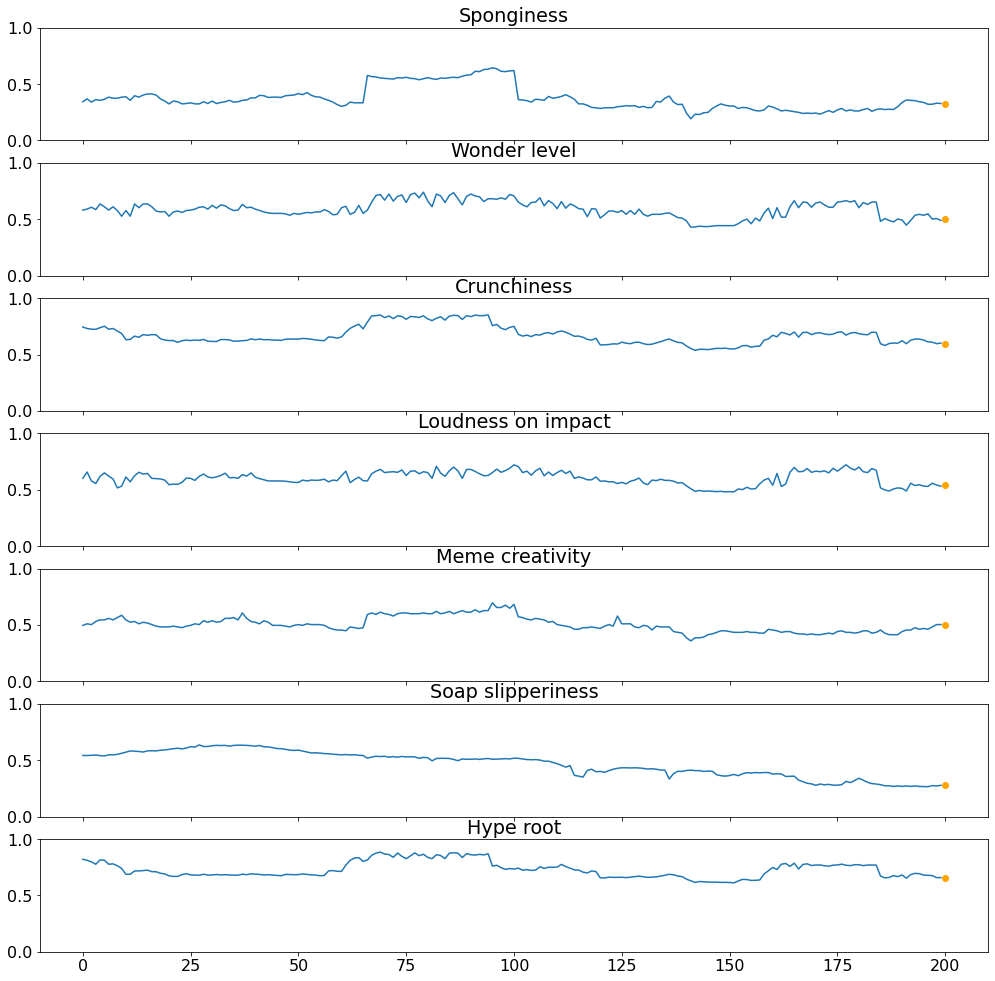

In [10]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [11]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [12]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(input_layer)
    convlstm = tfkl.Dropout(.1)(convlstm)
    convlstm = tfkl.LSTM(128, return_sequences=True, recurrent_dropout=0.2)(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.1)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    # Compile the model
    model.compile(loss = tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', 'mse', tfk.metrics.RootMeanSquaredError()])

    # Return the model
    return model

In [13]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 200, 64)           18432     
_________________________________________________________________
dropout (Dropout)            (None, 200, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          98816     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 903   

In [14]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-15 19:10:33.533363: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
87/87 [==============================] - 129s 1s/step - loss: 0.0794 - mae: 0.2092 - mse: 0.0794 - root_mean_squared_error: 0.2817 - val_loss: 0.0244 - val_mae: 0.1196 - val_mse: 0.0244 - val_root_mean_squared_error: 0.1563
Epoch 2/200
87/87 [==============================] - 122s 1s/step - loss: 0.0156 - mae: 0.0952 - mse: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0188 - val_mae: 0.1013 - val_mse: 0.0188 - val_root_mean_squared_error: 0.1371
Epoch 3/200
87/87 [==============================] - 122s 1s/step - loss: 0.0147 - mae: 0.0921 - mse: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0193 - val_mae: 0.1038 - val_mse: 0.0193 - val_root_mean_squared_error: 0.1389
Epoch 4/200
87/87 [==============================] - 120s 1s/step - loss: 0.0142 - mae: 0.0903 - mse: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0188 - val_mae: 0.1029 - val_mse: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 5/200
87/87 [==============================] - 123

In [15]:
model.save('trained/AutoregressionForecasting')
!zip -r DirectForecasting.zip  ./trained/AutoregressionForecasting
#model = tfk.models.load_model('DirectForecasting')

2022-01-15 22:30:52.260369: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: trained/AutoregressionForecasting/ (stored 0%)
  adding: trained/AutoregressionForecasting/variables/ (stored 0%)
  adding: trained/AutoregressionForecasting/variables/variables.index (deflated 67%)
  adding: trained/AutoregressionForecasting/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: trained/AutoregressionForecasting/saved_model.pb (deflated 89%)
  adding: trained/AutoregressionForecasting/assets/ (stored 0%)
  adding: trained/AutoregressionForecasting/keras_metadata.pb (deflated 90%)


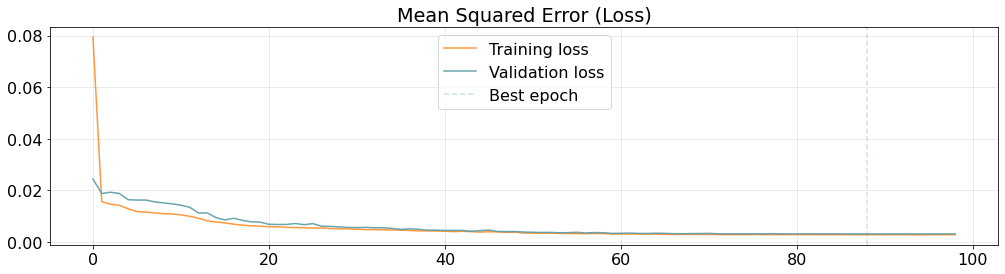

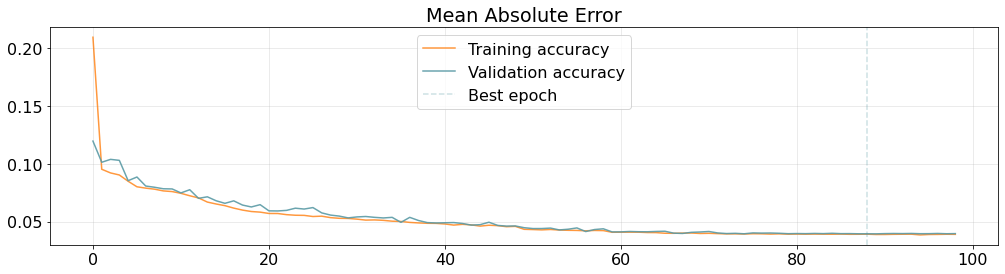

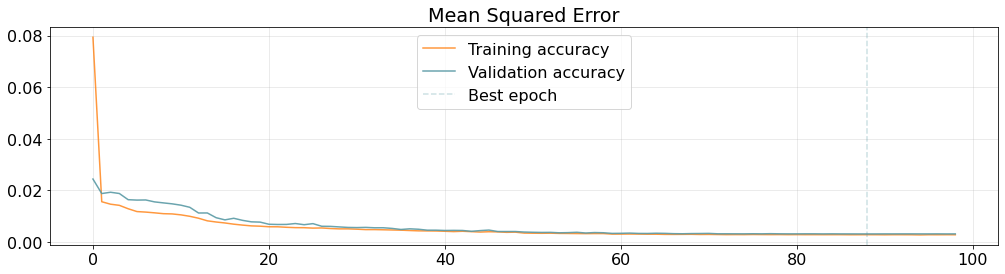

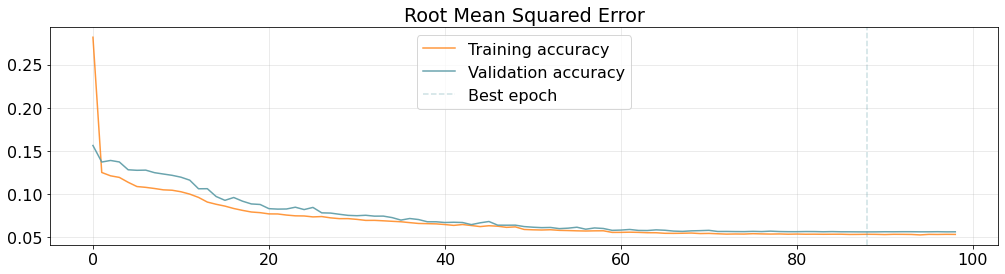

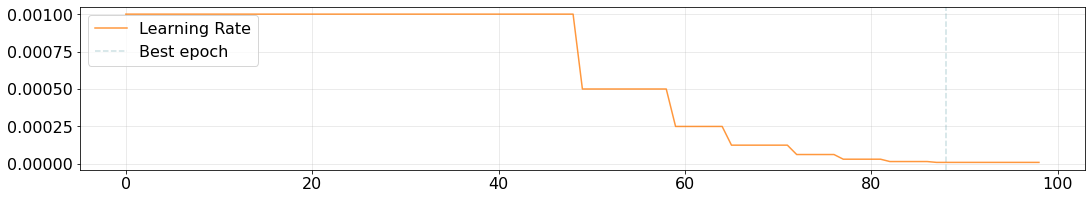

In [16]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mse'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['root_mean_squared_error'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_root_mean_squared_error'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Root Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [17]:
# Predict the test set 
predictions = model.predict(X_test)
#print(predictions.shape)

'''
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
root_mean_squared_error = tfk.metrics.RootMeanSquaredError()
root_mean_squared_error.update_state(y_test.flatten(),predictions.flatten())
print('RMSE: ', root_mean_squared_error.result().numpy())
print('MSE: ', mean_squared_error)
print('MAE: ', mean_absolute_error)
'''

"\nmean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())\nmean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())\nroot_mean_squared_error = tfk.metrics.RootMeanSquaredError()\nroot_mean_squared_error.update_state(y_test.flatten(),predictions.flatten())\nprint('RMSE: ', root_mean_squared_error.result().numpy())\nprint('MSE: ', mean_squared_error)\nprint('MAE: ', mean_absolute_error)\n"

In [18]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

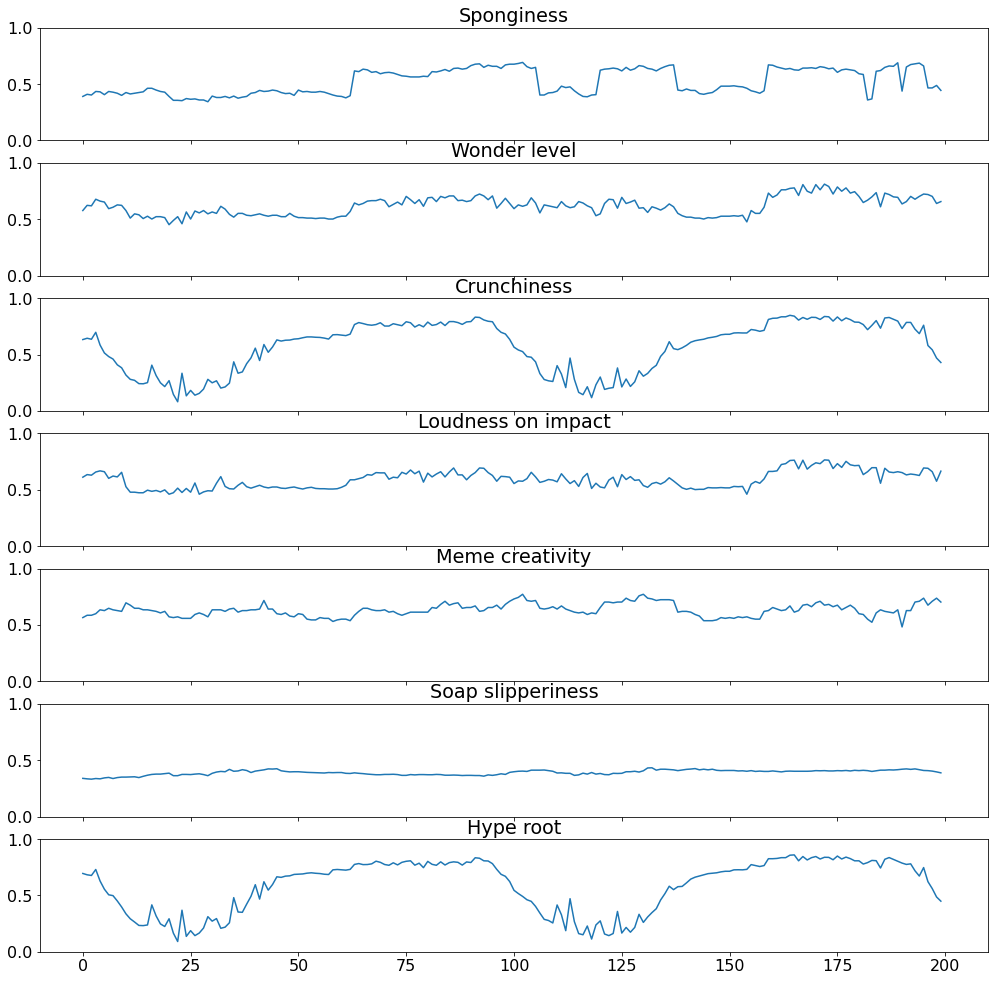

In [19]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [20]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((594, 200, 7), (594, 864, 7))

In [21]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [22]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
root_mean_squared_error = tfk.metrics.RootMeanSquaredError()
root_mean_squared_error.update_state(y_test_reg.flatten(),reg_predictions.flatten())
print('RMSE: ', root_mean_squared_error.result().numpy())
print('MSE: ', mean_squared_error)
print('MAE: ', mean_absolute_error)

RMSE:  0.11098986
MSE:  tf.Tensor(0.012318749, shape=(), dtype=float32)
MAE:  tf.Tensor(0.08045558, shape=(), dtype=float32)


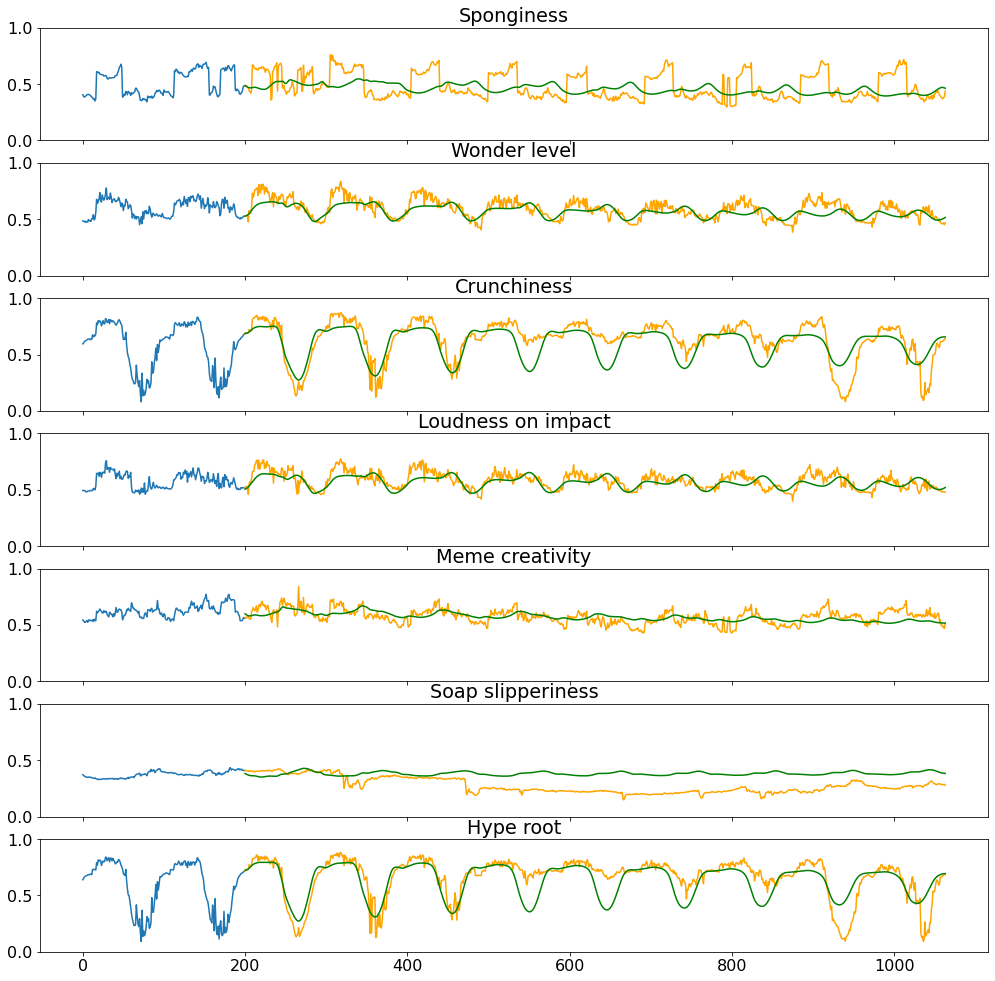

In [23]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

# Predict the future

In [24]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [25]:
reg_future = np.array([])
X_temp = future
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

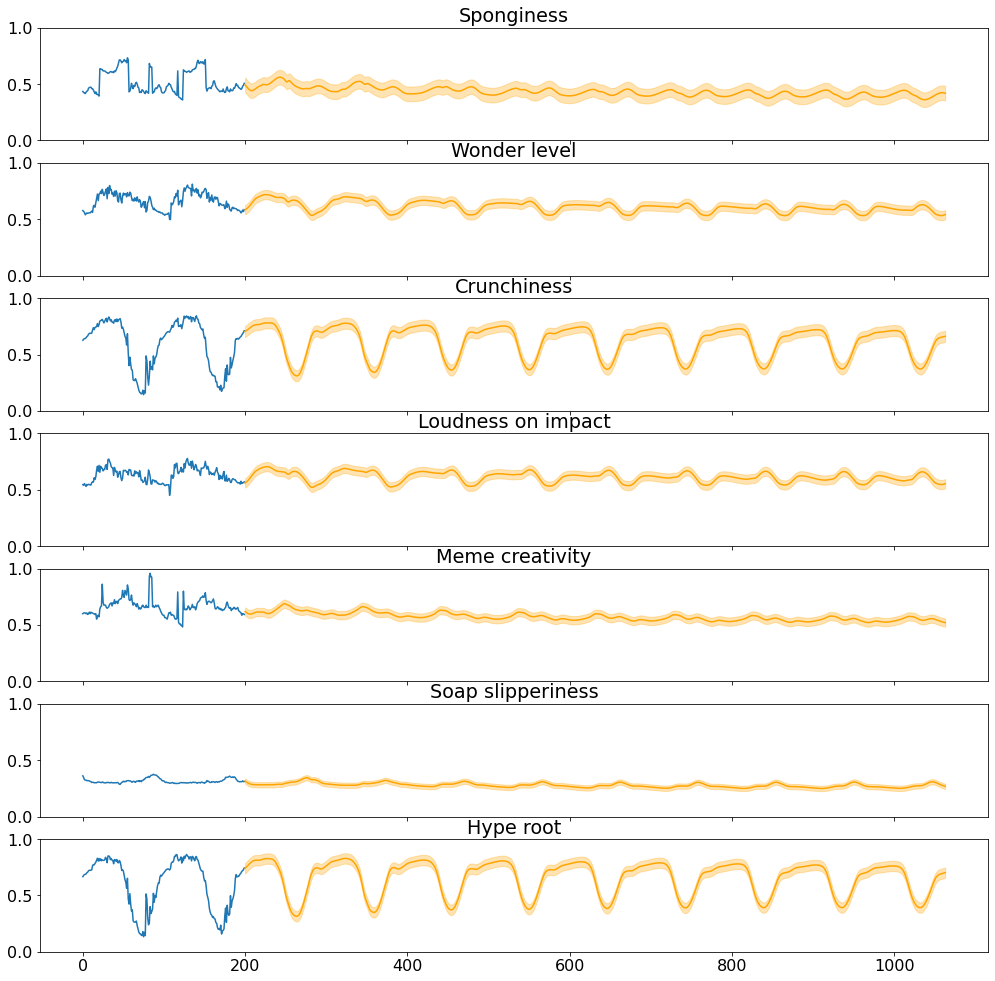

In [26]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()